
# "How to pick stocks for ORB strategy"

## 1. Get the stock information from yfinance or pandas_datareader

In [269]:
### 1. Get the stock information from yfinance or pandas_datareader
#Import  Required libraries 
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
import math

### Approach 1 for plotting trades(i.e using pandas_datarreader) 
### Picked Amazon from datareader

In [270]:
#set start date and end date

start_date='2018-01-01'
end_date ='2019-12-31'

#set the ticker

ticker='AMZN'
amzn_data= data.get_data_yahoo(ticker, start_date, end_date)
amzn_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,1190.000000,1170.510010,1172.000000,1189.010010,2694500,1189.010010
2018-01-03,1205.489990,1188.300049,1188.300049,1204.199951,3108800,1204.199951
2018-01-04,1215.869995,1204.660034,1205.000000,1209.589966,3022100,1209.589966
2018-01-05,1229.140015,1210.000000,1217.510010,1229.140015,3544700,1229.140015
2018-01-08,1253.079956,1232.030029,1236.000000,1246.869995,4279500,1246.869995


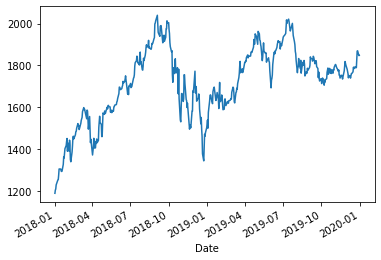

In [271]:
import matplotlib.pyplot as plt
%matplotlib inline
amzn_data['Adj Close'].plot()
plt.show()

### Problem with Approcah 1 is that it doesn't contain intraday data..
### So Approach 2 would be using yfinance library advantage is that it contains intraday data
### Picked Microsoft stock for analysis

In [272]:
#Using finance we can get more information of the stock
import yfinance as yf

In [273]:
#Getting 30 days data 
intraday30_data = yf.download(tickers="MSFT",
 period="1mo",
 interval="15m",auto_adjust=True)
intraday30_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Datetime,,,,,
2021-05-03 09:30:00-04:00,253.399994,253.690002,251.815002,252.490005,1866145
2021-05-03 09:45:00-04:00,252.324997,253.419998,252.270004,253.179993,949256
2021-05-03 10:00:00-04:00,253.179993,254.029999,252.669998,253.830002,1057161
2021-05-03 10:15:00-04:00,253.820007,254.250000,253.309998,253.739899,1214686
2021-05-03 10:30:00-04:00,253.740005,254.350006,253.580002,253.639999,900615


In [274]:
intraday30_data.tail()

,Open,High,Low,Close,Volume
Datetime,,,,,
2021-06-01 13:15:00-04:00,247.839996,247.919998,247.699997,247.869995,353458
2021-06-01 13:30:00-04:00,247.869995,248.050003,247.830002,247.860001,355520
2021-06-01 13:45:00-04:00,247.854996,248.279999,247.839996,248.268600,320179
2021-06-01 14:00:00-04:00,248.250000,248.250000,248.169998,248.190002,47308
2021-06-01 14:01:20-04:00,248.214996,248.214996,248.214996,248.214996,0


### Checking the datatypes of the dataframe received from yfinance

In [275]:
intraday30_data.dtypes
#here we can see Datetime is a row index

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [276]:
intraday30_data['Open'].iloc[1]

252.3249969482422

In [277]:
intraday30_data.iloc[-1]

Open      248.214996
High      248.214996
Low       248.214996
Close     248.214996
Volume      0.000000
Name: 2021-06-01 14:01:20-04:00, dtype: float64

In [278]:
intraday30_data.index[0]

Timestamp('2021-05-03 09:30:00-0400', tz='America/New_York')

#### Calculating the number of chunks the 1month dataframe data to be divided
#### Each day data is available from 9:30 to 3:45 with 15 min interval so total 26 rows for single day
#### Calculated how many Business days data is available = 22

In [291]:
#get the number of chunks to be made 
len(intraday30_data.loc['2021-05-28'])
# for single day we have 26 records
#number of chunks =no of days 
#len(intraday30_data)
#572
len(intraday30_data)/len(intraday30_data.loc['2021-05-28'])

#number of business days=22
noofdays=round(len(intraday30_data)/len(intraday30_data.loc['2021-05-28']))
noofdays
#round(21.7)

21

### 2. Prepare strategy ORB Opening Range Breakout
#### Input : Intraday dataframe  Output: Dataframe containing ORB strategic parameters

In [292]:
#Main Function get_ORB_parameters
#Input : Intraday dataframe
#Output : dataframe with details Buy trigger,short trigger and PnL calculation
#comparisions
#every 15 min Close will be compared with ORB_High and ORB_Low and new columns would be created)
#for comparision it is better to keep a average value

#copying the structure not the data for object instantiation
intraday_data=pd.DataFrame().reindex_like(intraday30_data)

ORB_parameters=pd.DataFrame(columns=['Date','ORB_High','ORB_Low','Buy_trigger','Short_trigger','Close_3pm','PnL','StopLoss_Hit'],index=range(noofdays))
#filling the missing values with 0's
ORB_parameters=ORB_parameters.fillna(0)

#changing from int to float for more precise calculations

ORB_parameters['ORB_High'] = ORB_parameters['ORB_High'].astype(float)
ORB_parameters['ORB_Low'] = ORB_parameters['ORB_Low'].astype(float)
ORB_parameters['Buy_trigger'] = ORB_parameters['Buy_trigger'].astype(float)
ORB_parameters['Short_trigger'] = ORB_parameters['Short_trigger'].astype(float)
ORB_parameters['PnL'] = ORB_parameters['PnL'].astype(float)
ORB_parameters['Close_3pm'] = ORB_parameters['Close_3pm'].astype(float)

def get_ORB_parameters(intraday_data,index):
    
    try:
        print("*****start******")
        
        
        intraday_data=intraday_data.iloc[:-3].copy()#Intraday drop last 3 rows in the dataframe i.e (3pm and above)
        
        ##not a efficient way to use copy method need to find alternatives
    
        #First row contains ORB High and ORB Low
    
        #ORB_parameters.iloc[index].Date    = intraday_data.index[0]
        #ORB_parameters.iloc[index].ORB_High= intraday_data.iloc[0].High
        #ORB_parameters.iloc[index].ORB_Low = intraday_data.iloc[0].Low
        #iloc doesn't work for assignments
        
        ORB_parameters.Date[index]   = intraday_data.index[0]
        ORB_parameters.ORB_High[index]= intraday_data.iloc[0].High
        ORB_parameters.ORB_Low[index] = intraday_data.iloc[0].Low
        ORB_parameters.Close_3pm[index]=intraday_data.iloc[-1].Close
        
        if len(intraday_data[intraday_data['Close'].gt(ORB_parameters.iloc[index].ORB_High)==True])> 0:
            
            ORB_parameters.Buy_trigger[index]=intraday_data[intraday_data['Close'].gt(ORB_parameters.iloc[index].ORB_High)==True].iloc[0]['Close']
            
        if len(intraday_data[intraday_data['Close'].lt(ORB_parameters.iloc[index].ORB_Low)==True])> 0:
            
            ORB_parameters.Short_trigger[index]=intraday_data[intraday_data['Close'].lt(ORB_parameters.iloc[index].ORB_Low)==True].iloc[0]['Close']
        
        print("*****reached half way in the code****")
    
        #Profit or loss calculation
        if ORB_parameters.iloc[index].Buy_trigger ==0 and ORB_parameters.iloc[index].Short_trigger ==0:
            
            ORB_parameters.PnL[index]=0
            
        elif ORB_parameters.iloc[index].Buy_trigger !=0:
            
            ORB_parameters.PnL[index]=intraday_data.iloc[-1].Close-ORB_parameters.iloc[index].Buy_trigger
            
        elif ORB_parameters.iloc[index].Short_trigger !=0:
            
            ORB_parameters.PnL[index]=ORB_parameters.iloc[index].Short_trigger-intraday_data.iloc[-1].Close  
        
        #column stoploss triggered
        if ORB_parameters.iloc[index].Buy_trigger !=0 and ORB_parameters.iloc[index].Short_trigger !=0:
            
            ORB_parameters.StopLoss_Hit[index]='Yes'
            
        else:
            if ORB_parameters.iloc[index].Buy_trigger ==0 and ORB_parameters.iloc[index].Short_trigger ==0:
                
                ORB_parameters.StopLoss_Hit[index]='NA'
                
            else:
                
                ORB_parameters.StopLoss_Hit[index]='No'
            
                 
        print("*****end*******")   
    except NameError:
        print ("This variable is not defined")    
        

## 3. Dividing the 1month dataset into 1 day chunks and passing it to above method

In [293]:
#make using of the method written with the slicing logic to get ORB_parameters df

n = 26  #chunk row size
[get_ORB_parameters(intraday30_data[i:i+n],math.floor(i/n)) for i in range(0,intraday30_data.shape[0],n)]


*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****s

<ipython-input-292-62aaf2c0df48>:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-292-62aaf2c0df48>:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-292-62aaf2c0df48>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-292-62aaf2c0df48>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******
*****start******
*****reached half way in the code****
*****end*******


<ipython-input-292-62aaf2c0df48>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-292-62aaf2c0df48>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-292-62aaf2c0df48>:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-292-62aaf2c0df48>:67: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## 4. Check the output dataframe for ORB parameters and visulizations

In [294]:
ORB_parameters

,Date,ORB_High,ORB_Low,Buy_trigger,Short_trigger,Close_3pm,PnL,StopLoss_Hit
0,2021-05-03 09:30:00-04:00,253.690002,251.815002,253.830002,251.203705,251.535004,-2.294998,Yes
1,2021-05-04 09:30:00-04:00,251.210007,249.500000,0.000000,249.130997,246.529999,2.600998,No
2,2021-05-05 09:30:00-04:00,249.339996,248.365005,0.000000,247.940002,246.675797,1.264206,No
3,2021-05-06 09:30:00-04:00,246.580002,244.949997,247.149994,0.000000,247.659897,0.509903,No
4,2021-05-07 09:30:00-04:00,252.580002,251.279999,253.260101,0.000000,253.199997,-0.060104,No
5,2021-05-10 09:30:00-04:00,251.330002,249.360001,251.380005,249.001205,248.109207,-3.270798,Yes
6,2021-05-11 09:30:00-04:00,245.000000,242.570099,245.164001,0.000000,245.440002,0.276001,No
7,2021-05-12 09:30:00-04:00,243.880005,242.139999,0.000000,241.460007,239.011597,2.448410,No
8,2021-05-13 09:30:00-04:00,243.190002,241.419998,243.279999,0.000000,243.979996,0.699997,No
9,2021-05-14 09:30:00-04:00,248.639999,245.490005,248.759995,0.000000,248.690002,-0.069992,No


### Stop Loss Hit Chart
### Stop loss has been hit only 2 days in 1month data
### 18 days Stop loss has not been hit It went to some Profit or loss on Microsoft stock

/home/david/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



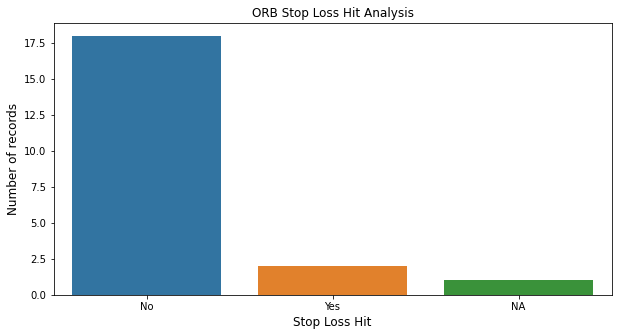

In [295]:
StopLoss_Hit_count  = ORB_parameters.StopLoss_Hit.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(StopLoss_Hit_count.index, StopLoss_Hit_count.values, alpha=1)
plt.title('ORB Stop Loss Hit Analysis')
plt.ylabel('Number of records', fontsize=12)
plt.xlabel('Stop Loss Hit', fontsize=12)
plt.show()


### Day wise profit and loss
### We can see that most of the days it made profits loss incurred for 4 days remaining all days it is profit

/home/david/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



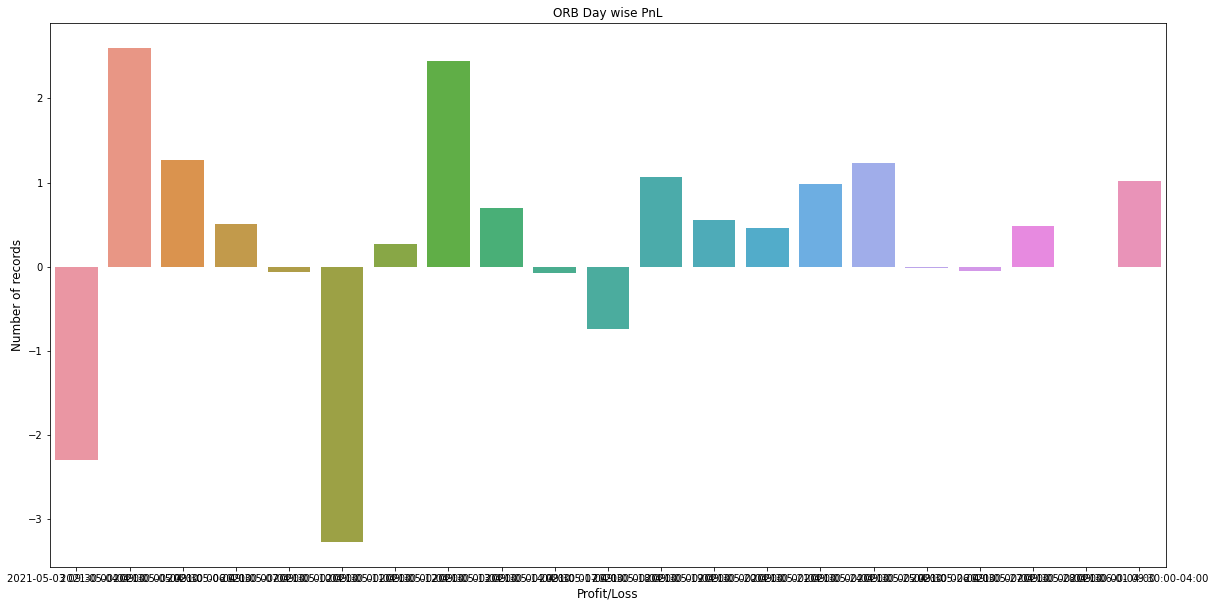

In [296]:
plt.figure(figsize=(20,10))
sns.barplot(ORB_parameters.Date, ORB_parameters.PnL, alpha=1)
plt.title('ORB Day wise PnL')
plt.ylabel('Number of records', fontsize=12)
plt.xlabel('Profit/Loss', fontsize=12)
plt.show()

### Total PnL for historic 1 month data
### So total of 7.08 dollars profit if daily this strategy is applied on microsoft stock
### Profit is less of Microsoft need to do analysis on other stocks 
### So by this analysis we can decide whether we can go for ORB strategy on the stock or not
### This is our analysis Happy Learning :-)


In [297]:
ORB_parameters.PnL.sum()

7.083526611328125

## End of Analysis 
### Below is for checking the strategy whether it has taken proper data or not

## 5.Testing the output generated by visualizing and checking for each day

In [302]:
# slicing the dataset into multiple dataframes based on dates
n = 26  #chunk row size
intraday30_data_list = [intraday30_data[i:i+n] for i in range(0,intraday30_data.shape[0],n)]
intraday30_data_list[2]
#now we can see that 30 days data has been divided into multiple chunks

,Open,High,Low,Close,Volume
Datetime,,,,,
2021-05-05 09:30:00-04:00,248.735001,249.339996,248.365005,249.089996,2397387
2021-05-05 09:45:00-04:00,249.266006,249.279999,248.520004,248.619995,3386113
2021-05-05 10:00:00-04:00,248.679993,248.759995,247.610001,247.940002,892130
2021-05-05 10:15:00-04:00,247.940002,248.210007,247.390106,248.110001,683094
2021-05-05 10:30:00-04:00,248.120300,248.729996,248.000000,248.460007,645445
2021-05-05 10:45:00-04:00,248.440002,248.600006,248.190002,248.369995,561443
2021-05-05 11:00:00-04:00,248.369995,248.580002,247.880005,247.889999,475282
2021-05-05 11:15:00-04:00,247.880005,248.300003,247.770004,248.039993,455651
2021-05-05 11:30:00-04:00,248.049896,248.490005,247.929993,248.279999,329479


### Visualizing the stock in candlesticks to better understand the data- we can pass the dataframes to understand the plots for every day
### Check  
### we can make use of above list intraday30_data_list for visualizing candle stick for each day

In [303]:
#Visualizing the stock
#15min chart for the MSFT stock for yesterday's movement
## It contains Datatime column as row index in the dataframe so we have to convert rowindex into a column
#convert the index column into column for visualization
#Converting row index into a column-- ignore coverting
intraday30_data_list[0]= intraday30_data_list[0].reset_index()

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers

fig = go.Figure(data=[go.Candlestick(x=intraday30_data_list[0]['Datetime'],
                      open=intraday30_data_list[0]['Open'],
                      high=intraday30_data_list[0]['High'],
                      low=intraday30_data_list[0]['Low'],
                      close=intraday30_data_list[0]['Close'])])

fig.show()

### Test Cells for debugging the code

In [213]:
#testing the errors faced
import numpy as np

df=pd.DataFrame(columns=['Date','ORB_High','ORB_Low','Buy_trigger','Short_trigger','PnL'],index=range(22))
df=df.fillna(0)

df.iloc[0].ORB_High != 0

intraday30_data[0:26].iloc[0].High

df.Date[0] = intraday30_data[0:26].index[1]

df


,Date,ORB_High,ORB_Low,Buy_trigger,Short_trigger,PnL
0,2021-04-29 09:45:00-04:00,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [232]:
#Test cells
get_ORB_parameters(intraday30_data[0:26],math.floor(0/26))


#len(intraday30_data[0:26][intraday30_data[0:26]['Close'].lt(255)==True])> 0

#intraday30_data[0:26][intraday30_data[0:26]['Close'].lt(255)==True].iloc[0]['Close']

*****start******
length of short: 0
log2
*****reached half way in the code****
index: {0} 0
*****end*******


<ipython-input-231-45489dd97868>:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-45489dd97868>:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-45489dd97868>:36: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-231-45489dd97868>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-45489dd97868>:61: SettingWithCopyWarning:


A value is t

In [234]:
ORB_parameters.dtypes

Date             object
ORB_High          int64
ORB_Low           int64
Buy_trigger       int64
Short_trigger     int64
PnL               int64
dtype: object

### Debug magic command

In [168]:
%debug

> /home/david/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py(1437)_validate_integer()
   1435         len_axis = len(self.obj._get_axis(axis))
   1436         if key >= len_axis or key < -len_axis:
-> 1437             raise IndexError("single positional indexer is out-of-bounds")
   1438 
   1439     # -------------------------------------------------------------------

ipdb> idex
*** NameError: name 'idex' is not defined
ipdb> index
*** NameError: name 'index' is not defined
ipdb> quit()


### Another example for visualization using plotly and graphical objects

In [23]:
#import plotly.graph_objects as go
#Another example for candle stick chart
import pandas as pd
from datetime import datetime

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['AAPL.Open'],
                high=df['AAPL.High'],
                low=df['AAPL.Low'],
                close=df['AAPL.Close'])])

fig.show()